In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

titlesize = 15
labelsize = 15
legendsize = 12
xticksize = 15
yticksize = xticksize

plt.rcParams['legend.markerscale'] = 1.5     # the relative size of legend markers vs. original
plt.rcParams['legend.handletextpad'] = 0.5
plt.rcParams['legend.labelspacing'] = 0.4    # the vertical space between the legend entries in fraction of fontsize
plt.rcParams['legend.borderpad'] = 0.5       # border whitespace in fontsize units
plt.rcParams['font.size'] = 12
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams['axes.labelsize'] = labelsize
plt.rcParams['axes.titlesize'] = titlesize
plt.rcParams['figure.figsize'] = (15, 6)
#plt.rcParams['image.cmap'] = 'tab20c'

plt.rc('xtick', labelsize=xticksize)
plt.rc('ytick', labelsize=yticksize)
plt.rc('legend', fontsize=legendsize)

Доля ошибок первого рода: 0.21


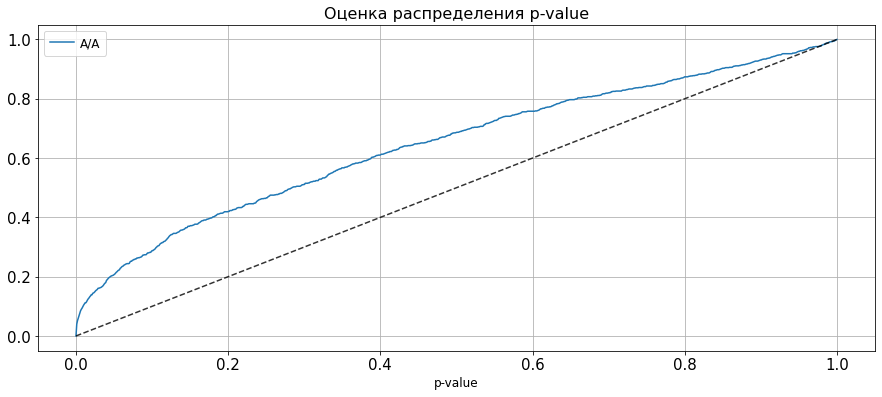

In [5]:
def plot_pvalue_distribution(dict_pvalues):
    """Рисует графики распределения p-value."""
    X = np.linspace(0, 1, 1000)
    for name, pvalues in dict_pvalues.items():
        Y = [np.mean(pvalues < x) for x in X]
        plt.plot(X, Y, label=name)

    plt.plot([0, 1], [0, 1], '--k', alpha=0.8)
    plt.title('Оценка распределения p-value', size=16)
    plt.xlabel('p-value', size=12)
    plt.legend(fontsize=12)
    plt.grid()
    plt.show()

def generate_data(sample_size, effect):
    """Генерирует данные со стоимостью покупок.

    Возвращает два списка с данными контрольной и экспериментальной групп.
    Элементы списков - множества со стоимостями покупок пользователей. 
    """
    result = []
    for group_effect in [0, effect]:
        n_purchases = np.random.randint(1, 5, sample_size)
        mean_costs = np.random.uniform(1000, 2000, sample_size)
        data = [
            np.random.normal(mean + group_effect, 200, n)
            for n, mean in zip(n_purchases, mean_costs)
        ]
        result.append(data)
    return result

alpha = 0.05              # допустимая вероятность ошибки I рода
sample_size = 1000        # размер групп

pvalues = []
for _ in range(1000):
    a, b = generate_data(sample_size, 0)
    a_values = np.hstack(a)
    b_values = np.hstack(b)
    pvalue = stats.ttest_ind(a_values, b_values).pvalue
    pvalues.append(pvalue)

error_rate = np.mean(np.array(pvalues) < alpha)
print(f'Доля ошибок первого рода: {error_rate:0.2f}')
plot_pvalue_distribution({'A/A': pvalues})

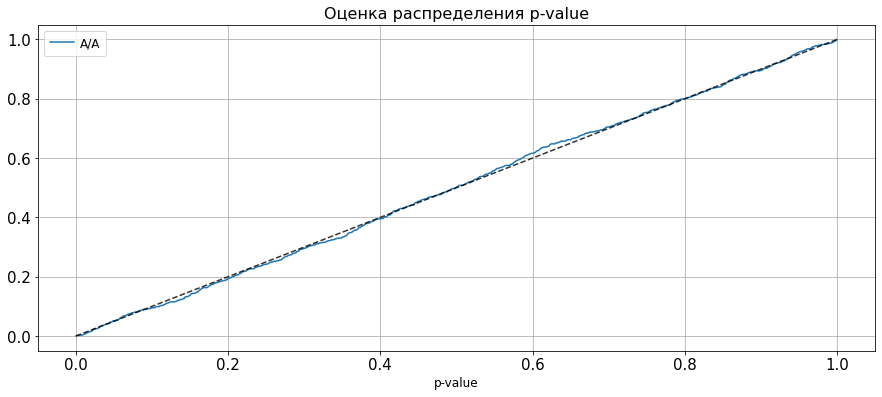

In [6]:
pvalues = []
for _ in range(1000):
    a, b = generate_data(sample_size, 0)
    a_means = [np.mean(x) for x in a]
    b_means = [np.mean(x) for x in b]
    pvalue = stats.ttest_ind(a_means, b_means).pvalue
    pvalues.append(pvalue)

plot_pvalue_distribution({'A/A': pvalues})

In [7]:
def get_percentile_ci(bootstrap_stats, alpha):
    """Строит перцентильный доверительный интервал."""
    left, right = np.quantile(bootstrap_stats, [alpha / 2, 1 - alpha / 2])
    return left, right

def check_bootsrtap(a, b, n_iter, alpha):
    """Оценивает значимость отличий с помощью бутстрепа.

    Если отличия значимые, то возвращает 1, иначе 0.
    """
    # вычисляем стоимость и количество покупок клиентов
    xy_a = np.array([[sum(values), len(values)] for values in a])
    xy_b = np.array([[sum(values), len(values)] for values in b])
    # генерируем случайные индексы для выбора подмножеств данных
    len_a = len(a)
    len_b = len(b)
    indexes_a = np.random.choice(
        np.arange(len_a), size=(n_iter, len_a), replace=True
    )
    indexes_b = np.random.choice(
        np.arange(len_b), size=(n_iter, len_b), replace=True
    )

    bootstrap_stats = []
    for idx_a, idx_b in zip(indexes_a, indexes_b):
        bootstrap_xy_a = xy_a[idx_a]
        bootstrap_xy_b = xy_b[idx_b]
        # считаем разницу метрик отношения
        bootstrap_stat = (
            bootstrap_xy_b[:, 0].sum() / bootstrap_xy_b[:, 1].sum()
            - bootstrap_xy_a[:, 0].sum() / bootstrap_xy_a[:, 1].sum()
        )
        bootstrap_stats.append(bootstrap_stat)
    # строим доверительный интервал и оцениваем значимость отличий
    ci = get_percentile_ci(bootstrap_stats, alpha)
    has_effect = 1 - (ci[0] < 0 < ci[1])
    return has_effect

alpha = 0.05               # допустимая вероятность ошибки I рода
sample_size = 1000         # размер групп
n_iter = 1000              # количество итераций бутстрепа

effects = []
for _ in range(1000):
    a, b = generate_data(sample_size, 0)
    has_effect = check_bootsrtap(a, b, n_iter, alpha)
    effects.append(has_effect)

error_rate = np.mean(np.array(effects) == 1)
print(f'Доля ошибок первого рода: {error_rate:0.3f}')

Доля ошибок первого рода: 0.061


group a mean_x, mean_y: 3706.640924397479 2.487
group a var_x, var_y: 3401711.934148824 1.2538310000000001
cov_xy: 1842.8445232788686
group b mean_x, mean_y: 3793.6201095604565 2.508
group b var_x, var_y: 3710092.4725530203 1.2439359999999997
cov_xy: 1930.2557693869744


{'pe_metric_a': 1490.4064834730514,
 'var_metric_a': 112.15316588269157,
 'pe_metric_b': 1512.6076991867849,
 'var_metric_b': 113.95054765609797}

group a mean_x, mean_y: 3759.5116228225424 2.501
group a var_x, var_y: 3507490.700080742 1.2559990000000003
cov_xy: 1859.1538772840906
group b mean_x, mean_y: 3836.762978429039 2.501
group b var_x, var_y: 3642329.5521623916 1.267999
cov_xy: 1924.1425566221064


{'pe_metric_a': 1503.2033677819043,
 'var_metric_a': 120.89508533603069,
 'pe_metric_b': 1534.0915547497157,
 'var_metric_b': 115.56568789387443}

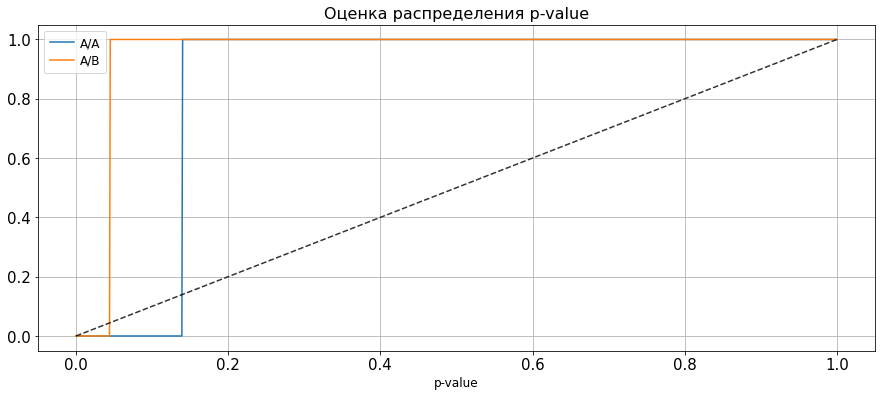

In [10]:
def check_delta_method(a, b):
    """Проверка гипотезы с помощью дельта-метода.

    Возвращает p-value.
    """
    dict_ = {}
    for data, group_name in [(a, 'a',), (b, 'b',)]:
        n_user = len(data)
        array_x = np.array([np.sum(row) for row in data])
        array_y = np.array([len(row) for row in data])
        mean_x, mean_y = np.mean(array_x), np.mean(array_y)
        print(f'group {group_name} mean_x, mean_y:', mean_x, mean_y)
        var_x, var_y = np.var(array_x), np.var(array_y)
        print(f'group {group_name} var_x, var_y:', var_x, var_y)
        cov_xy = np.cov(array_x, array_y)[0, 1]
        print(f'cov_xy:', cov_xy)
        # точечная оценка метрики
        pe_metric = np.sum(array_x) / np.sum(array_y)
        # оценка дисперсии метрики
        var_metric = (
            var_x / mean_y ** 2
            - 2 * (mean_x / mean_y ** 3) * cov_xy
            + (mean_x ** 2 / mean_y ** 4) * var_y
        ) / n_user
        dict_[f'pe_metric_{group_name}'] = pe_metric
        dict_[f'var_metric_{group_name}'] = var_metric
    display(dict_)
    var = dict_['var_metric_a'] + dict_['var_metric_b']
    delta = dict_['pe_metric_b'] - dict_['pe_metric_a']
    t = delta / np.sqrt(var)
    pvalue = (1 - stats.norm.cdf(np.abs(t))) * 2
    return pvalue

alpha = 0.05           # допустимая вероятность ошибки I рода
sample_size = 1000     # размер групп
effect = 50            # размер эффекта

pvalues_aa = []
pvalues_ab = []
for _ in range(1000):
    a, b = generate_data(sample_size, 0)
    pvalues_aa.append(check_delta_method(a, b))
    a, b = generate_data(sample_size, effect)
    pvalues_ab.append(check_delta_method(a, b))
    break

plot_pvalue_distribution({'A/A': pvalues_aa, 'A/B': pvalues_ab})